In [168]:
import numpy as np
import pandas as pd
import pickle   

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [169]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

In [170]:
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (10, 8)})
matplotlib.rcParams.update({'font.size': 14})

In [171]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
PREPARED_TRAIN_DATASET_PATH = './prepared_train.csv'
SAMPLE_SUBMISSION_PATH = './sample_submission.csv'

In [172]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Загрузка данных

- **train.csv** - тренировочный набоp  
- **test.csv** - тестовый набор

#### Поля данных

- **Id** - идентификационный номер квартиры  
- **DistrictId** - идентификационный номер района  
- **Rooms** - количество комнат
- **Square** - площадь 
- **LifeSquare** - жилая площадь 
- **KitchenSquare** - площадь кухни  
- **Floor** - этаж 
- **HouseFloor** - количество этажей в доме 
- **HouseYear** - год постройки дома 
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
- **Social_1, Social_2, Social_3** - социальные показатели местности  
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровьем 
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров 
- **Price** - цена квартиры

In [173]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [174]:
df = df.set_index('Id')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


#### Анализ таргета

In [175]:
print('минимум цены: ', df['Price'].min())
print('максимум цены: ', df['Price'].max())
print('Медиана: ', df['Price'].median())
print('Средняя цена: ', df['Price'].mean())
print('Мода: ', df['Price'].mode()[0])

минимум цены:  59174.777
максимум цены:  633233.44
Медиана:  192269.66
Средняя цена:  214138.86
Мода:  182938.08


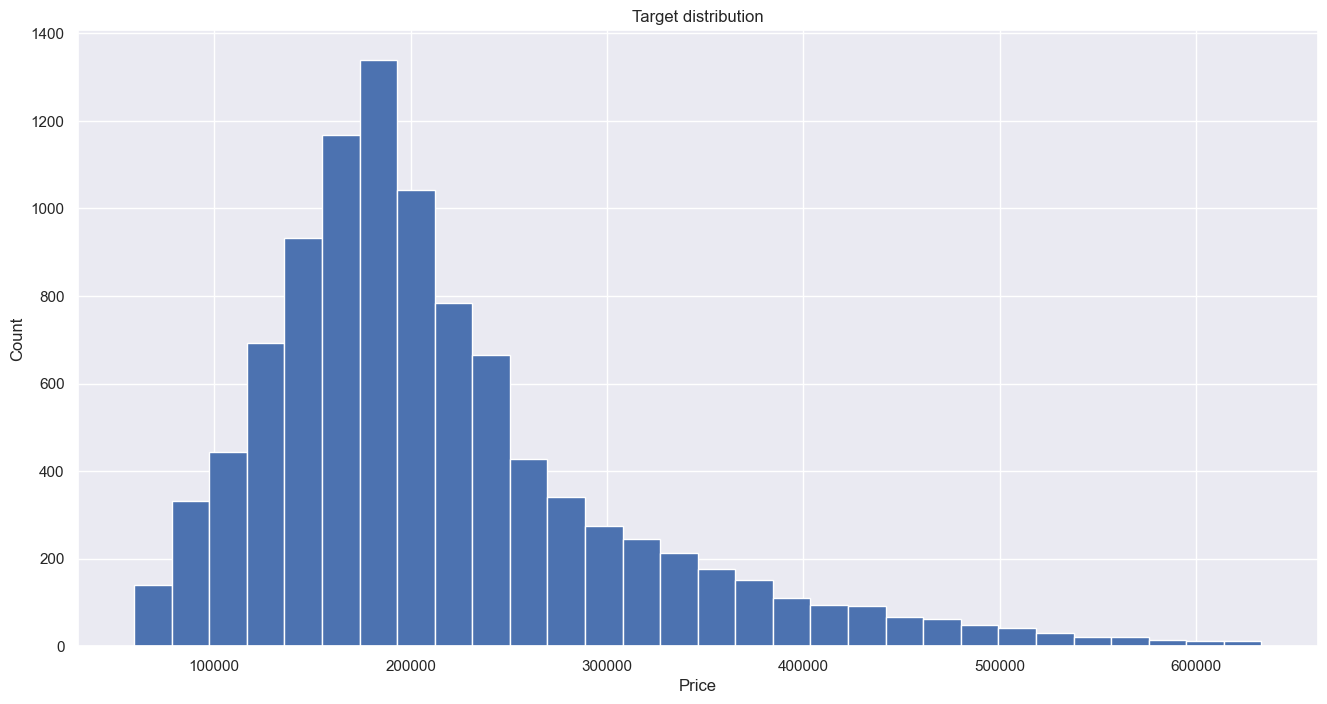

In [176]:
plt.figure(figsize=(16, 8))
df['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Target distribution')

plt.show()

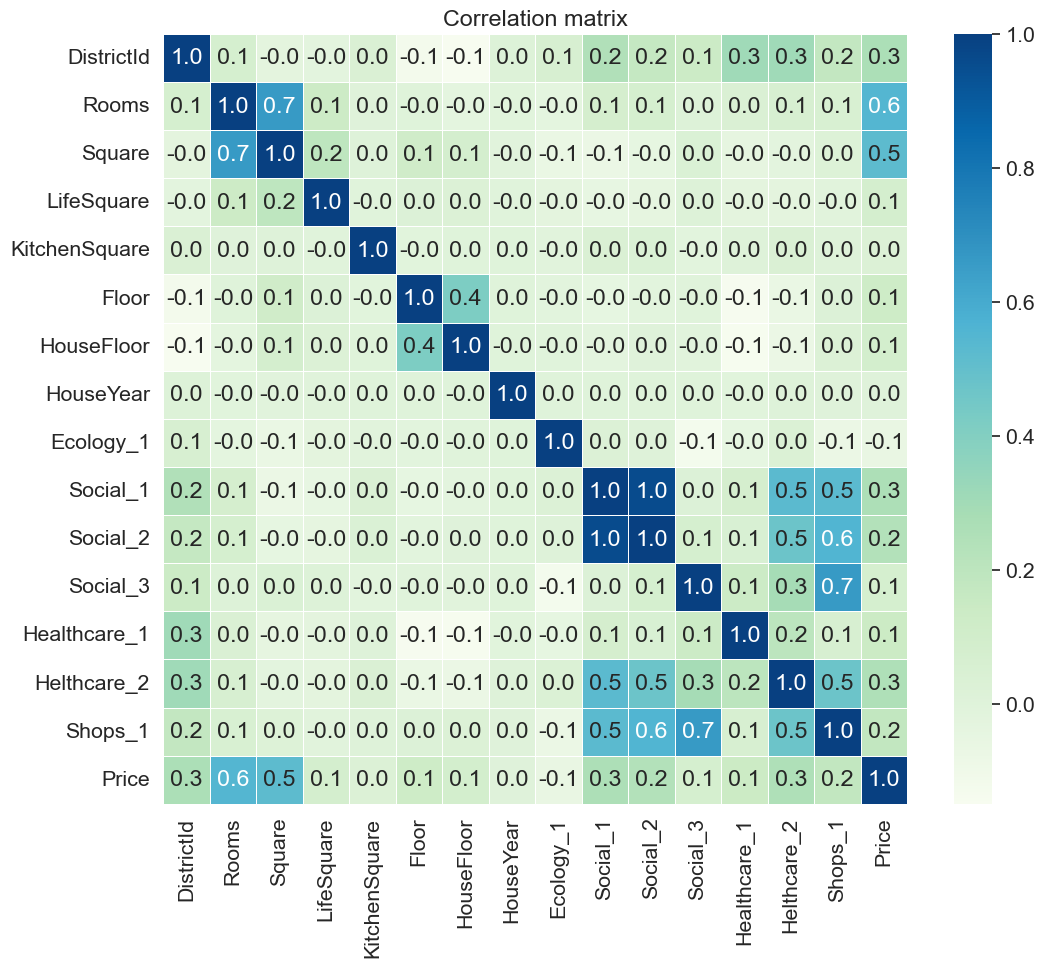

In [177]:
# Построим матрицу корреляций
corr_matrix = df.corr()
plt.figure(figsize = (12, 10))
sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Основными признаками, оказывающими влияние на цену квартиры, по матрице корреляций: Площадь квартиры(0,5) и колличество комнат(0,6). Также стоит отметить, зависимость социальных факторов 1 и 2.

In [178]:
# Проанализируем данные
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

In [179]:
# В параметре Healthcare_1 отсутствует почти половина данных и корреляция его с Price всего 0.1. 
# Данный параметр не может быть оценен объективно и оказывает слабое влияние на Price (r2 практически без изменения).
# Удалим его
df = df.drop('Healthcare_1', axis=1)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315777,21.058731,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199646,86.241211,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


У нас не полные данные LifeSquare. Не хватает примерно трети. Это значительное количество. Проверим достоверность данных, чтобы принять решение - удалить данные или дополнить. Для этого найдем недостоверные данные:

1. LifeSquare > Square
2. LifeSquare > max Square
3. LifeSquare < 10

In [180]:
df.loc[(df['LifeSquare'] > df['Square']) | (df['LifeSquare'] < 10) | (df['LifeSquare'] > 641)].shape

(680, 18)

Еще 680 данных недостоверны. Кроме того корреляция с Price 0.1. Удалим LifeSquare.

In [181]:
df = df.drop('LifeSquare', axis=1)
df.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.937500
15053,41,3.0,65.683640,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.437500
4765,53,2.0,44.947952,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.906250
5809,58,2.0,53.352982,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375
10783,99,1.0,39.649193,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531250


In [182]:
# Рассмотрим квартиры с Square меньше 10
df.loc[df['Square']  < 10]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,3,9,B,412511.093750
11526,27,1.0,4.633498,1.0,18,1.0,1977,0.011654,B,B,4,915,0,0,0,B,107604.265625
10202,6,1.0,2.596351,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,0,0,B,137597.593750
10527,27,1.0,4.380726,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,0,1,B,97560.718750
9487,5,1.0,5.129221,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,4,5,B,369472.406250
3224,27,0.0,2.377248,0.0,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.945312
4504,27,3.0,4.390331,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,0,1,B,161379.062500
14786,1,1.0,1.136859,1.0,3,1.0,1977,0.007122,B,B,1,264,0,0,1,B,181434.828125
13265,1,3.0,4.823679,0.0,6,17.0,1977,0.007122,B,B,1,264,0,0,1,B,237716.687500


In [183]:
# Нет ни одной Square пригодной для проживания. 
# Предположим, что в данных ошибка в порядке и умножим эти данные на 10.
df.loc[df['Square']  < 10, 'Square'] = df.loc[df['Square']  < 10, 'Square']*10 

In [184]:
df.loc[df['Square']  < 20]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
13685,0,1.0,17.498543,0.0,7,5.0,1961,0.319809,B,B,25,4756,16,5,8,B,88871.750000
15127,150,1.0,17.046188,8.0,7,12.0,1982,0.300323,B,B,52,10311,6,1,9,B,74222.109375
523,101,1.0,18.509176,3.0,5,5.0,1970,0.225825,A,B,41,6558,7,3,2,B,115845.859375
12676,81,3.0,13.784864,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,5,8,B,78388.804688
15877,57,3.0,16.547241,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,3,4,A,77835.187500
14786,1,1.0,11.368588,1.0,3,1.0,1977,0.007122,B,B,1,264,0,0,1,B,181434.828125
12927,62,2.0,17.414181,1.0,4,20.0,1977,0.072158,B,B,2,629,1,0,0,A,180750.468750
6927,21,1.0,16.117155,0.0,2,5.0,1965,0.194489,B,B,47,8004,3,3,5,B,79913.265625
10635,21,1.0,18.983963,2.0,1,5.0,1967,0.194489,B,B,47,8004,3,3,5,B,112411.218750


In [185]:
# Найдем квартиры с площадью комнаты меньше 10
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
16395,2,3.0,79.722244,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,1,9,B,370148.625000
5927,57,10.0,59.056976,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,5,15,B,317265.312500
1315,6,1.0,48.128113,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,0,0,B,146950.906250
14656,62,1.0,47.100719,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,0,0,A,108337.484375
9690,27,1.0,40.081043,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,0,1,B,93218.648438
2371,27,2.0,68.841072,66.0,4,2.0,2014,0.017647,B,B,2,469,0,0,0,B,189244.250000
8491,1,19.0,42.006046,7.0,17,17.0,2014,0.007122,B,B,1,264,0,0,1,B,78364.617188
12507,54,2.0,79.810532,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,6,6,B,438708.718750
4265,161,2.0,53.216778,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,0,3,B,261125.671875


In [186]:
# Изменим количество комнат на 1
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10, 'Rooms'] = 1
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
16395,2,1.0,79.722244,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,1,9,B,370148.625000
1315,6,1.0,48.128113,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,0,0,B,146950.906250
14656,62,1.0,47.100719,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,0,0,A,108337.484375
9690,27,1.0,40.081043,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,0,1,B,93218.648438
2371,27,1.0,68.841072,66.0,4,2.0,2014,0.017647,B,B,2,469,0,0,0,B,189244.250000
12507,54,1.0,79.810532,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,6,6,B,438708.718750
4265,161,1.0,53.216778,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,0,3,B,261125.671875
12390,72,1.0,97.490677,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,3,0,B,445074.968750
7441,62,1.0,114.734474,112.0,3,3.0,2015,0.072158,B,B,2,629,1,0,0,A,315245.531250


In [187]:
# Можно допустить, что комната одна и она совмещена с кухней, поэтому их площади равны или близки по значениюю
# Выберем квартиры, где кухня больше площади.
df.loc[df['Square'] < df['KitchenSquare']]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,0,0,A,108337.484375
13703,42,1.0,38.071693,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,1,0,B,160488.031250
6569,27,1.0,38.220257,84.0,4,17.0,2018,0.011654,B,B,4,915,0,0,0,B,99079.960938
14679,81,1.0,32.276665,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,6,6,B,105539.554688


In [188]:
# В двух площади кухни явно перепутаны с годами. Заменим их на 0.
# В двух других скорее всего значения площади и кухни перепутаны местами
# Исправим это
df.loc[df['KitchenSquare'] > 1000, 'KitchenSquare'] = 0
df.loc[df['Square'] < df['KitchenSquare']]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
13703,42,1.0,38.071693,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,1,0,B,160488.031250
6569,27,1.0,38.220257,84.0,4,17.0,2018,0.011654,B,B,4,915,0,0,0,B,99079.960938


In [189]:
a = np.array([df.loc[df['Square'] < df['KitchenSquare'], 'Square']])
a

array([[38.071693, 38.220257]], dtype=float32)

In [190]:
df.loc[df['Square'] < df['KitchenSquare'], 'Square'] = df['KitchenSquare']
df.loc[df['Square'] == df['KitchenSquare']]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
13703,42,1.0,73.0,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,1,0,B,160488.031250
6569,27,1.0,84.0,84.0,4,17.0,2018,0.011654,B,B,4,915,0,0,0,B,99079.960938


In [191]:
b, c = a[0, 0], a[0, 1]
df.loc[df['Square'] == df['KitchenSquare'], 'KitchenSquare'] = b, c
# Проверим
df.loc[(df['Square'] == 73) | (df['Square'] == 84)]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
13703,42,1.0,73.0,38.071693,9,10.0,2006,0.158249,B,B,21,5731,0,1,0,B,160488.031250
6569,27,1.0,84.0,38.220257,4,17.0,2018,0.011654,B,B,4,915,0,0,0,B,99079.960938


In [192]:
# Найдем выбросы в HouseYear
df.loc[df['HouseYear'] > 2023]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265072,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,3,6,B,254084.531250
11607,147,2.0,44.791836,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,5,8,B,243028.609375


In [193]:
df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2005
df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [194]:
# Проверим дома с 0 этажей и этажем квартиры выше, чем этажей в доме
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor'])].shape

(1825, 17)

In [195]:
# Заменим значения HouseFloor на Floor
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor']), 'HouseFloor'] = df['Floor']

In [196]:
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor'])].shape

(0, 17)

In [197]:
# Рассмотрим категориальные признаки
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [198]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [199]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [200]:
# Заменим В на 1 и А на 0 и тип на int
df['Ecology_2'] = (df['Ecology_2'] == 'B').astype(int)
df['Ecology_2'].value_counts()

1    9903
0      97
Name: Ecology_2, dtype: int64

In [201]:
df['Ecology_3'] = (df['Ecology_3'] == 'B').astype(int)
df['Ecology_3'].value_counts()

1    9725
0     275
Name: Ecology_3, dtype: int64

In [202]:
df['Shops_2'] = (df['Shops_2'] == 'B').astype(int)
df['Shops_2'].value_counts()

1    9175
0     825
Name: Shops_2, dtype: int64

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int8   
 5   HouseFloor     10000 non-null  float32
 6   HouseYear      10000 non-null  int32  
 7   Ecology_1      10000 non-null  float32
 8   Ecology_2      10000 non-null  int32  
 9   Ecology_3      10000 non-null  int32  
 10  Social_1       10000 non-null  int8   
 11  Social_2       10000 non-null  int16  
 12  Social_3       10000 non-null  int16  
 13  Helthcare_2    10000 non-null  int8   
 14  Shops_1        10000 non-null  int8   
 15  Shops_2        10000 non-null  int32  
 16  Price          10000 non-null  float32
dtypes: float32(6), int16(3), int32(4), int8(4)
memo

In [204]:
df.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.882200,56.363819,5.866829,8.526700,13.435700,1984.865700,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.917500,214138.859375
std,43.587592,0.811905,20.996410,5.091614,5.241148,6.094012,18.411517,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.289062
min,0.000000,0.000000,11.368588,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.787090,1.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.535437,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.648438
75%,75.000000,2.000000,65.912855,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.460938
max,209.000000,5.000000,641.065186,123.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.437500


#### Сохраняем и разбиваем на тестовый и тренировочный

In [205]:
df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

In [206]:
target = pd.DataFrame(df['Price'], columns=['Price'])
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   10000 non-null  float32
dtypes: float32(1)
memory usage: 375.2 KB


In [207]:
data_columns = df.columns[: -1]
data_columns

Index(['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
       'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [208]:
data = df[data_columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int8   
 5   HouseFloor     10000 non-null  float32
 6   HouseYear      10000 non-null  int32  
 7   Ecology_1      10000 non-null  float32
 8   Ecology_2      10000 non-null  int32  
 9   Ecology_3      10000 non-null  int32  
 10  Social_1       10000 non-null  int8   
 11  Social_2       10000 non-null  int16  
 12  Social_3       10000 non-null  int16  
 13  Helthcare_2    10000 non-null  int8   
 14  Shops_1        10000 non-null  int8   
 15  Shops_2        10000 non-null  int32  
dtypes: float32(5), int16(3), int32(4), int8(4)
memory usage: 785.4 KB


In [209]:
y = target
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
X_train.shape

(7500, 16)

In [210]:
# Применим модель RandomForest.
rf = RandomForestRegressor(random_state=21)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

In [211]:
y_predict_train = rf.predict(X_train)
r2_score(y_train, y_predict_train)

0.9614135340918204

In [212]:
y_predict_test = rf.predict(X_test)
r2_score(y_test, y_predict_test)

0.7238939536741833

In [213]:
# Перекрестная проверка
cv_score = cross_val_score(rf, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72142913, 0.71538346, 0.73677944])

In [214]:
cv_score.mean()

0.7245306779718731

In [215]:
# Важность признаков
feature_importans = pd.DataFrame(zip(X_train.columns, rf.feature_importances_),
                                columns=('Feature name', 'importance'))
feature_importans.sort_values(by='importance', ascending=False)

,Feature name,importance
2,Square,0.400942
10,Social_1,0.113033
11,Social_2,0.081355
1,Rooms,0.080985
12,Social_3,0.058669
0,DistrictId,0.051224
7,Ecology_1,0.044296
6,HouseYear,0.041685
5,HouseFloor,0.034503
4,Floor,0.032496


In [216]:
# Ecology_3, Ecology_2 практически не оказывают влияние на результат. Их можно удалить.
df = df.drop('Shops_2', axis=1)
df = df.drop('Ecology_3', axis=1)
df = df.drop('Ecology_2', axis=1)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.882200,0.811905,0.000000,1.000000,2.000000,2.000000,5.000000
Square,10000.0,56.363819,20.996410,11.368588,41.787090,52.535437,65.912855,641.065186
KitchenSquare,10000.0,5.866829,5.091614,0.000000,1.000000,6.000000,9.000000,123.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,13.435700,6.094012,1.000000,9.000000,14.000000,17.000000,117.000000
HouseYear,10000.0,1984.865700,18.411517,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,19083.000000


In [217]:
df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
y = pd.DataFrame(df['Price'], columns=['Price'])
data_columns = df.columns[: -1]
X = df[data_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
rf = RandomForestRegressor(random_state=21)
rf.fit(X_train, y_train)
y_predict_train = rf.predict(X_train)
print(r2_score(y_train, y_predict_train))
y_predict_test = rf.predict(X_test)
print(r2_score(y_test, y_predict_test))
cv_score = cross_val_score(rf, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
print(cv_score.mean())

0.9615055179976659
0.7244469417064017
0.724852892160376


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int8   
 5   HouseFloor     10000 non-null  float32
 6   HouseYear      10000 non-null  int32  
 7   Ecology_1      10000 non-null  float32
 8   Social_1       10000 non-null  int8   
 9   Social_2       10000 non-null  int16  
 10  Social_3       10000 non-null  int16  
 11  Helthcare_2    10000 non-null  int8   
 12  Shops_1        10000 non-null  int8   
 13  Price          10000 non-null  float32
dtypes: float32(6), int16(3), int32(1), int8(4)
memory usage: 707.3 KB


In [221]:
# Сохраним данные
df = pd.read_csv(TEST_DATASET_PATH)
df = df.set_index('Id')
df = df.drop(['Shops_2','Healthcare_1', 'LifeSquare', 'Ecology_3', 'Ecology_2'], axis=1)
df.loc[df['Square']  < 10, 'Square'] = df.loc[df['Square']  < 10] * 10
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10, 'Rooms'] = 1
df.loc[df['KitchenSquare'] > 1000, 'KitchenSquare'] = 0
a = np.array([df.loc[df['Square'] < df['KitchenSquare'], 'Square']])
df.loc[df['Square'] < df['KitchenSquare'], 'Square'] = df['KitchenSquare']
for i in range(0, len(a) - 1):
    df.loc[df['Square'] == df['KitchenSquare'], 'KitchenSquare'] = a[0, i]
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor']), 'HouseFloor'] = df['Floor']
df.loc[df['HouseYear'] > 2023, 'HouseYear'] = 2023
y_predict = rf.predict(df).round(2)
df['Price'] = y_predict
df.to_csv(SAMPLE_SUBMISSION_PATH, columns=['Price'], encoding='utf-8')

In [222]:
# Проверим сохранение файла
df_ss = pd.read_csv(SAMPLE_SUBMISSION_PATH)
df_ss.head(10)

,Id,Price
0,725,163263.43
1,15856,229668.63
2,5480,222816.12
3,15664,338714.96
4,14275,147200.90
5,7633,215912.83
6,13329,182046.96
7,5502,226170.90
8,4220,301609.86
9,11538,206991.06
